# Offensive AI Course Homework
* Course website: https://ymirsky.github.io/course/
* Course edition: 2023
* Lecturer: Dr. Yisroel Mirsky

## Instructions
* This homework can be done in groups of two 
* Make a copy of this notebook and solve the problems below.
* Do not use the ART toolbox in this homework
* Orgnization: In each section there are two cells: (1) a cell with a function with some missing code where you must complete the missing code (do not change the existing code), (2) a cell to test your code. Before you submit your work, make sure that the test cell in every section can run your code.
* Submission: (1) generate a sharable link to your notebook, (2) submit your link by [clicking here](https://docs.google.com/forms/d/e/1FAIpQLSfdNTv2XOPxxurgK7626VbaPMsmEvv_yW3ObBSwTtcHdd3m0g/viewform?usp=sharing)  
* Deadline: submit your homework no later than December 14th. Each day past the deadline is -15 pnts


## Sections:
1. BIM (50 points)
2. Random Starts (15 points)
3. Masking (20 points)
4. Color Limited Attacks (15 points)
5. PGD (bonus 10 points)




# Setup

These cells will setup your environment


In [27]:
#### Load Modules ####

import os
import json
import math
import time
import numpy as np 
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"

# Setting the seed
#pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
#torch.backends.cudnn.determinstic = True
#torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [28]:
#### load dataset ####

import urllib.request
from urllib.error import HTTPError
import zipfile
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])


#### load and setup victim model (resnet34) ####

# Load CNN architecture pretrained on ImageNet
victim_model = torchvision.models.resnet34(pretrained=True)
victim_model = victim_model.to(device)

# No gradients needed for the network
victim_model.eval()
for p in victim_model.parameters():
    p.requires_grad = False

# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=NORM_MEAN,std=NORM_STD)])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " 
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)
    
def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worke

In [29]:
#### Some helper functions to compute and view results ####

def eval_model(victim_model, dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels) 
        with torch.no_grad():
            preds = victim_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5

def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):
    
    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()
    
    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})
    
    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')
    
    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).detach().numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).detach().numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1 
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')
    
    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().detach().numpy(), topk_idx.cpu().detach().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')
    
    plt.show()
    plt.close()

Let's make sure the victim model is setup correctly

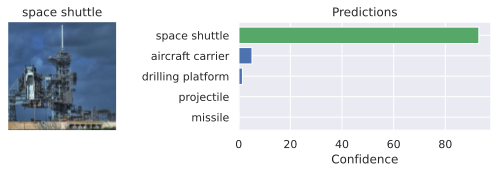

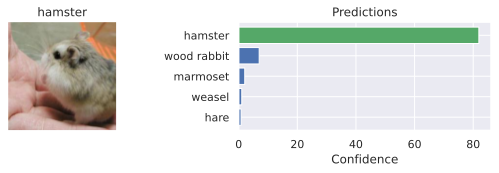

In [ ]:
exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = victim_model(exmp_batch.to(device))
for i in range(0,5):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

# 1. BIM

In this section, complete the code below to impliment the BIM algorithm. 

Features:
* The user should be able to choose if the attack is targeted or not targeted
* If ``targeted==True``, then BIM should perform a targeted attack using ``labels`` as the target labels. The labels should be class indexes, e.g., ``labels=tensor([23, 4, 7])``
* If ``targeted==False``, then ``labels`` should contain the actual labels for the batch and BIM should perform an untargeted attack.

Reminders:
* alpha is the gradient step size to be applied to ``adv_images``
* eps is the bound of how far ``adv_images`` is allowed to travel from ``images``



In [ ]:
def BIM(model, images, labels, eps=0.3, alpha=0.01, steps=2, targeted=False,  pixelclip=(-2.6,2.6)):

    images = images.clone().to(device)
    labels = labels.clone().to(device)
    loss = nn.CrossEntropyLoss()

    ### Change or move code from here on ###
    original_images = images.data
    adv_images = images.clone().detach()
    
    for step in range(steps):
      adv_images.requires_grad = True
      preds = model(adv_images)
      model.zero_grad()

      # Calculate loss 
      # if targeted==True the labels are the targets labels else they are just the ground truth labels
      cost = loss(preds, labels)
      cost.backward()
      
      # Grad is calculated
      delta = alpha*adv_images.grad.sign()
      
      # Stop following gradient changes
      adv_images = adv_images.detach()

      # Update adversarial images
      if targeted:
        # Minimize - so it's with mins sign
        adv_images = adv_images -  delta
      else:
        # Maxmize - so it's with plus sign
        adv_images= adv_images + delta

      # Clip the change between the adverserial images and the original images to an epsilon range
      eta = torch.clamp(adv_images - original_images, min=-eps, max=eps)

      # detach to start from a fresh start images object (avoiding gradient tracking)
      adv_images = torch.clamp(original_images + eta, min=pixelclip[0], max=pixelclip[1])


    ### Don't change this code:

    return adv_images, delta  # grad is the gradient (pertubation)

In [ ]:
# Untargeted attacks
adv_imgs_ut, noise_grad_ut = BIM(victim_model, exmp_batch, label_batch, eps=0.3, alpha=.01, steps=10, targeted=False,  pixelclip=(-2.6,2.6))
with torch.no_grad():
    adv_preds_ut = victim_model(adv_imgs_ut.to(device))


# Targeted attacks
targets = (label_batch + 100) % 1000
adv_imgs_t, noise_grad_t = BIM(victim_model, exmp_batch, targets, eps=0.3, alpha=.01, steps=10, targeted=True,  pixelclip=(-2.6,2.6))
with torch.no_grad():
    adv_preds_t = victim_model(adv_imgs_t.to(device))
    
print("Untargeted Results")
for i in range(0,5):
    show_prediction(exmp_batch[i], label_batch[i], adv_preds_ut[i], adv_img=adv_imgs_ut[i], noise=100*noise_grad_ut[i])
print("Targeted Results")
for i in range(0,5):
    show_prediction(exmp_batch[i], label_batch[i], adv_preds_t[i], adv_img=adv_imgs_t[i], noise=100*noise_grad_t[i])

# 2. Projected Gradient Descent

Now let's add random starts to BIM to make it PGD.
A random start is where we start BIM near x in an attempt to find a better solution. This is accomplished by using x + n in the first iteration, where n contains random values and where x + n is within the distance epsilon from x

Feature to impliment:
* Let the user choose whether the algorithm should use a random start or not. There is no need to run the algorithm multiple times (just change the starting position)

Copy your code below to the function ``PGD`` and add the option for a random start

In [ ]:
def PGD(model, images, labels, eps=0.3, alpha=0.01, steps=10, targeted=False, random_start=True, pixelclip=(-2.6,2.6)):

    images = images.clone().to(device)
    original_images = images.data

    labels = labels.clone().to(device)
    loss = nn.CrossEntropyLoss()
    original_images = images.data

    ### Change or move code from here on ###
    adv_images = images.clone().detach()

    if random_start:
      adv_images = adv_images + torch.empty_like(images).uniform_(-eps, eps)
      adv_images = torch.clamp(adv_images, pixelclip[0], pixelclip[1])

    for step in range(steps):
      adv_images.requires_grad = True
      preds = model(adv_images)
      model.zero_grad()

      # Calculate loss 
      # if targeted==True the labels are the targets labels else they are just the ground truth labels
      cost = loss(preds, labels)
      cost.backward()
      
      # Grad is calculated
      delta = alpha*adv_images.grad.sign()
      
      # Stop following gradient changes
      adv_images = adv_images.detach()

      # Update adversarial images
      if targeted:
        # Minimize - so it's with mins sign
        adv_images = adv_images -  delta
      else:
        # Maxmize - so it's with plus sign
        adv_images= adv_images + delta

      # Clip the change between the adverserial images and the original images to an epsilon range
      eta = torch.clamp(adv_images - original_images, min=-eps, max=eps)

      # detach to start from a fresh start images object (avoiding gradient tracking)
      adv_images = torch.clamp(original_images + eta, min=pixelclip[0], max=pixelclip[1])


    ### Don't change this code:

    return adv_images, delta  # grad is the gradient (pertubation)

In [ ]:
# let try several trials of BIM on the same image
preds = []
for i in range(40):
  adv_imgs, noise_grad = PGD(victim_model, exmp_batch[0:1], label_batch[0:1], eps=0.3, alpha=.01, steps=50, targeted=False, random_start=True, pixelclip=(-2.6,2.6))
  with torch.no_grad():
    pred = victim_model(adv_imgs.to(device))[0,label_batch[0]].cpu().detach().numpy()
    preds.append( pred )
    
plt.hist(preds)
plt.title("Confidence Distribution Among Attacks on same Image. Lower is better")

# 3. Masked Attacks

In some cases an attack is limited to a certain region within the image. In this section, upgrade your ``PGD`` procedure so that it will only add a pertubation to one half of an image, yet still fool the victim.

Features:
* Let the user choose whether to add a pertubation to the left half, right half, or entire image.

Hint: you can multiply a tensor with a tensor of zeroes and ones to erase (focus) on relevant pixels.

In [ ]:
def PGDsm(model, images, labels, eps=0.3, alpha=0.01, steps=10, targeted=False, random_start=True, mask=None, pixelclip=(-2.6,2.6)):   
    # for each random start:
    if mask is None:
      M = torch.ones(images.shape[1:])
    if mask == "left":
      M = torch.zeros(images.shape)
      M[:, :, :, :images.shape[3]//2] = 1
    if mask == "right":
      M = torch.zeros(images.shape)
      M[:, :, :, images.shape[3]//2:] = 1
      
    M = M.clone().to(device)
    images = images.clone().to(device)
    original_images = images.data

    labels = labels.clone().to(device)
    loss = nn.CrossEntropyLoss()
    original_images = images.data

    ### Change or move code from here on ###
    adv_images = images.clone().detach()

    if random_start:
      adv_images = adv_images + M*torch.empty_like(images).uniform_(-eps, eps)
      adv_images = torch.clamp(adv_images, pixelclip[0], pixelclip[1])

    for step in range(steps):
      adv_images.requires_grad = True
      preds = model(adv_images)
      model.zero_grad()

      # Calculate loss 
      # if targeted==True the labels are the targets labels else they are just the ground truth labels
      cost = loss(preds, labels)
      cost.backward()
      
      # Grad was calculated
      delta = M*alpha*adv_images.grad.sign()
      
      # Stop following gradient changes
      adv_images = adv_images.detach()

      # Update adversarial images
      if targeted:
        # Minimize - so it's with mins sign
        adv_images = adv_images -  delta
      else:
        # Maxmize - so it's with plus sign
        adv_images= adv_images + delta

      # Clip the change between the adverserial images and the original images to an epsilon range
      eta = torch.clamp(adv_images - original_images, min=-eps, max=eps)

      # detach to start from a fresh start images object (avoiding gradient tracking)
      adv_images = torch.clamp(original_images + eta, min=pixelclip[0], max=pixelclip[1])


    return adv_images, delta  # grad is the gradient (pertubation)

In [ ]:
# Untargeted attacks
adv_imgs_ut, noise_grad_ut = PGDsm(victim_model, exmp_batch, label_batch, eps=0.3, alpha=.01, steps=10, targeted=False, mask="left", pixelclip=(-2.6,2.6))
with torch.no_grad():
    adv_preds_ut = victim_model(adv_imgs_ut.to(device))

# Targeted attacks
targets = (label_batch + 100) % 1000
adv_imgs_t, noise_grad_t = PGDsm(victim_model, exmp_batch, targets, eps=0.3, alpha=.01, steps=10, targeted=True, mask="left", pixelclip=(-2.6,2.6))
with torch.no_grad():
    adv_preds_t = victim_model(adv_imgs_t.to(device))
    
print("Untargeted Results")
for i in range(0,5):
    show_prediction(exmp_batch[i], label_batch[i], adv_preds_ut[i], adv_img=adv_imgs_ut[i], noise=100*noise_grad_ut[i])
print("Targeted Results")
for i in range(0,5):
    show_prediction(exmp_batch[i], label_batch[i], adv_preds_t[i], adv_img=adv_imgs_t[i], noise=100*noise_grad_t[i])

# 4. Color Limited Attacks

Now we want to change a specific color channel of the image (e.g., attack the victim by making the image more red in certain pixels)

Features:
* Let the user choose which channels the pertubation should modify: red, green, blue, or all together (default).

In [ ]:
# def PGDsmc(model, images, labels, eps=0.3, alpha=0.01, steps=10, targeted=False, random_start=True, mask=None, channel=None, pixelclip=(-2.6,2.6)):   
#     # for each random start...
#       if mask is None:
#         M = torch.ones(images.shape[1:])
#       if mask == "left":
#         M = torch.ones(images.shape[1:])
#         M[:,:images.shape[1]//2,:] = 1
#       if mask == "right":
#         M = torch.ones(images.shape[1:])
#         M[:,images.shape[1]//2:,:] = 1   
      
#     #...if channel...

#     return adv_images, pertubations

In [ ]:
def PGDsmc(model, images, labels, eps=0.3, alpha=0.01, steps=10, targeted=False, random_start=True, mask=None, channel=None, pixelclip=(-2.6,2.6)):   

    # for each random start:
    if mask is None:
      M = torch.ones(images.shape[1:])
    if mask == "left":
      M = torch.zeros(images.shape)
      M[:, :, :, :images.shape[3]//2] = 1
    if mask == "right":
      M = torch.zeros(images.shape)
      M[:, :, :, images.shape[3]//2:] = 1
    
    if channel is None:
      CM = torch.ones(images.shape[1:])

    if 'red' in channel:
      CM = torch.zeros(images.shape)
      CM[:, 0, :, :] = 1
    if 'green' in channel:
      CM = torch.zeros(images.shape)
      CM[:, 1, :, :] = 1

    if 'blue' in channel:
      CM = torch.zeros(images.shape)
      CM[:, 2, :, :] = 1
      
    total_mask = (M*CM).clone().to(device)
    images = images.clone().to(device)
    original_images = images.data

    labels = labels.clone().to(device)
    loss = nn.CrossEntropyLoss()
    original_images = images.data

    ### Change or move code from here on ###
    adv_images = images.clone().detach()

    if random_start:
      adv_images = adv_images + total_mask*torch.empty_like(images).uniform_(-eps, eps)
      adv_images = torch.clamp(adv_images, pixelclip[0], pixelclip[1])

    for step in range(steps):
      adv_images.requires_grad = True
      preds = model(adv_images)
      model.zero_grad()

      # Calculate loss 
      # if targeted==True the labels are the targets labels else they are just the ground truth labels
      cost = loss(preds, labels)
      cost.backward()
      
      # Grad was calculated
      delta = total_mask*alpha*adv_images.grad.sign()
      
      # Stop following gradient changes
      adv_images = adv_images.detach()

      # Update adversarial images
      if targeted:
        # Minimize - so it's with mins sign
        adv_images = adv_images -  delta
      else:
        # Maxmize - so it's with plus sign
        adv_images= adv_images + delta

      # Clip the change between the adverserial images and the original images to an epsilon range
      eta = torch.clamp(adv_images - original_images, min=-eps, max=eps)

      # detach to start from a fresh start images object (avoiding gradient tracking)
      adv_images = torch.clamp(original_images + eta, min=pixelclip[0], max=pixelclip[1])


    return adv_images, delta  # grad is the gradient (pertubation)

In [ ]:
# Untargeted attacks
adv_imgs_ut, noise_grad_ut = PGDsmc(victim_model, exmp_batch, label_batch, eps=0.3, alpha=.01, steps=10, targeted=False, mask=None, channel="red",  pixelclip=(-2.6,2.6))
with torch.no_grad():
    adv_preds_ut = victim_model(adv_imgs_ut.to(device))

# Targeted attacks
targets = (label_batch + 100) % 1000
adv_imgs_t, noise_grad_t = PGDsmc(victim_model, exmp_batch, targets, eps=0.3, alpha=.01, steps=10, targeted=True, mask=None, channel= "red", pixelclip=(-2.6,2.6))
with torch.no_grad():
    adv_preds_t = victim_model(adv_imgs_t.to(device))
    
print("Untargeted Results")
for i in range(0,5):
    show_prediction(exmp_batch[i], label_batch[i], adv_preds_ut[i], adv_img=adv_imgs_ut[i], noise=100*noise_grad_ut[i])
print("Targeted Results")
for i in range(0,5):
    show_prediction(exmp_batch[i], label_batch[i], adv_preds_t[i], adv_img=adv_imgs_t[i], noise=100*noise_grad_t[i])

# 5. P-norms (bonus 10 points)
Give PGD the ability to use different p-norms while computing the magnitude of delta

Features:
* Let the user choose which norm to use ($\ell_0$, $\ell_1$, $\ell_2$, $\ell_\infty$)

In this excersize, use the given norm for computing the gradient update only. Demonstrate results. 